# PDG API tutorial, PyHEP 2024

## Introduction

The goal of this tutorial is to provide a set of examples that illustrate the main features of the API. Basic familiarity with Python is assumed. Comprehensive documentation is available at https://pdgapi.lbl.gov/doc/

## Installation

First, create a virtual environment and activate it:

```bash
python -m venv ~/pdg.venv
source ~/pdg.venv/bin/activate
```

This ensures that any dependencies will be installed in a self-contained environment.

Now install the package:

```bash
pip install pdg
```

In order to run the examples in this notebook, some additional packages are required:

```bash
pip install numpy matplotlib jupyter
```

You can now launch a Jupyter session (`jupyter lab`) and open this notebook.

## Preamble

The examples that follow all assume that the following preamble has been run:

In [1]:
import pdg
from pdg.particle import PdgParticle
import matplotlib.pyplot as plt
import numpy as np

api = pdg.connect()

If `pedantic=True` is passed to `pdg.connect`, the API will run in *pedantic* mode, where it will make minimal assumptions, in some cases requiring you to be more explicit about what you are asking for. Such cases are mentioned below.

Now let's get started!

## The basics

### Getting a particle

Particles are represented by the `PdgParticle` class. There are multiple ways to get a particle from the API. Depending on the method, the result can be a `PdgParticleList`, a Python list of `PdgParticle`s, or a specific `PdgParticle`.

#### By name

A particle name can refer to a single particle or to a group of them. The function `get_particle_by_name` will return a `PdgParticle` if there's a unique match, and will raise an exception if not. The function `get_particles_by_name` always returns a list of `PdgParticles`. Aliases will automatically be resolved.

In [2]:
api.get_particle_by_name('pi+')

PdgParticle('S008/2024', name='pi+')

In [3]:
api.get_particles_by_name('pi')

[PdgParticle('S008/2024', name='pi-'),
 PdgParticle('S009/2024', name='pi0'),
 PdgParticle('S008/2024', name='pi+')]

#### By MC ID

Since MC IDs are unambiguous, `get_particle_by_mcid` returns a `PdgParticle` directly.

In [4]:
api.get_particle_by_mcid(2212)

PdgParticle('S016/2024', name='p')

#### By PDG identifier

PDG identifiers correspond to pages on pdgLive and are shown on the page and URL. An identifier can refer to, e.g., a particle, or a set of measurements (e.g. masses) for a particle, or more general measurements, such as mixing angles. The `get` function, given a particle's PDG identifier, returns a list of all `PdgParticle`s associated to the ientifier. Since `get` must return an instance of a `PdgData` subclass, the return type is a `PdgParticleList`, rather than a simple list of `PdgParticle`s.

In [5]:
plist = api.get('S008/2024')
plist

PdgParticleList('S008/2024')

However, a simple list is simple to get:

In [6]:
list(plist)

[PdgParticle('S008/2024', name='pi+'), PdgParticle('S008/2024', name='pi-')]

### Getting quantum numbers

Quantum numbers are associated directly with a `PdgParticle` and can always be accessed as attributes.

In [7]:
p = api.get_particle_by_name('pi0')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '1', '-', '0', '-', '+')

In [8]:
p = api.get_particle_by_name('pi+')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(1.0, '1', '-', '0', '-', None)

### Getting masses, widths, and lifetimes

Masses, widths, and lifetimes are the main particle properties provided by the API. In some cases there may be multiple identifiers for masses (or widths or lifetimes) for a given particle, corresponding to different techniques or assumptions. A given particle may have width or lifetime properties, but not both.

The `masses`, `widths`, and `lifetimes` methods provide iterators over these properties.

In [9]:
p = api.get_particle_by_name('pi+')
list(p.masses())

[PdgMass('S008M/2024')]

In [10]:
list(p.widths())

[]

In [11]:
list(p.lifetimes())

[PdgLifetime('S008T/2024')]

The `PdgMass`, `PdgWidth`, and `PdgLifetime` classes are all subclasses of `PdgProperty`, which provides a `summary_values` function that produces a list of `SummaryTableValue` objects:

In [12]:
m = api.get('S008M')
m

PdgMass('S008M/2024')

In [13]:
m.summary_values()

[{'id': 1021180,
  'pdgid_id': 1283,
  'pdgid': 'S008M',
  'edition': '2024',
  'value_type': 'FC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 139.5703909836813,
  'error_positive': 0.0001820071604082601,
  'error_negative': 0.0001820071604082601,
  'scale_factor': 1.76094,
  'unit_text': 'MeV',
  'display_value_text': '139.57039+-0.00018',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'pi+- MASS'},
 {'id': 1021181,
  'pdgid_id': 1283,
  'pdgid': 'S008M',
  'edition': '2024',
  'value_type': 'AC',
  'in_summary_table': False,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 139.5703909836813,
  'error_positive': 0.0001693589698941287,
  'error_negative': 0.0001693589698941287,
  'scale_factor': 1.638568,
  'unit_text': 'MeV',
  'display_value_text': '139.57039+-0.00017',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 2,
  'de

Human-readable information on summary values is available via attributes:

In [14]:
sv = m.summary_values()
sv[0].value_type, sv[1].value_type

('OUR FIT', 'OUR AVERAGE')

In this case, we see that two summary values are provided for `S008M`, corresponding to the PDG fit and average.

A given summary value is encoded in whatever units are considered most appropriate. The encoded value and units can be accessed via the `value` and `units` attributes. The `get_value` method can be used to get the value in specified units.

In [15]:
v = m.summary_values()[0]

v.value, v.units, v.get_value('GeV')

(139.5703909836813, 'MeV', 0.13957039098368132)

The `error`, `error_positive`, and `error_negative` attributes, and the `get_error` method, are analogous:

In [16]:
v.error, v.error_positive, v.error_negative, v.get_error('GeV')

(0.0001820071604082601,
 0.0001820071604082601,
 0.0001820071604082601,
 1.8200716040826008e-07)

For convenience, the `mass`, `width`, and `lifetime` attributes of a `PdgParticle` can be used to get the "best" (i.e. first) summary value, in standard units of GeV and seconds. Normally, widths and lifetimes are automatically interconverted when necessary. (In pedantic mode, this does not occur, and there must be exactly one matching property identifier and summary value, or a `PdgNoDataError` will be thrown.)

In [17]:
p.mass, p.width, p.lifetime

(0.13957039098368132, 2.5283166082854054e-17, 2.603313199949126e-08)

The top quark provides an example where there are multiple mass properties:

In [18]:
p = api.get_particle_by_name('t')

list(p.masses())

[PdgMass('Q007TP/2024'), PdgMass('Q007TP2/2024'), PdgMass('Q007TP4/2024')]

In [19]:
[m.description for m in p.masses()]

['t-Quark Mass (Direct Measurements)',
 't-Quark Mass from Cross-Section Measurements',
 't-Quark Pole Mass from Cross-Section Measurements']

### Getting decays

In addition to masses and widths/lifetimes, a particle can have one or more branching fraction properties (which are either inclusive or exclusive):

In [20]:
p = api.get_particle_by_name('pi+')

We can easily get all of the branching fractions of the $\pi^+$:

In [21]:
list(p.branching_fractions())

[PdgBranchingFraction('S008.1/2024', "pi+ --> mu+ nu_mu"),
 PdgBranchingFraction('S008.3/2024', "pi+ --> mu+ nu_mu gamma"),
 PdgBranchingFraction('S008.2/2024', "pi+ --> e+ nu_e"),
 PdgBranchingFraction('S008.5/2024', "pi+ --> e+ nu_e gamma"),
 PdgBranchingFraction('S008.4/2024', "pi+ --> e+ nu_e pi0"),
 PdgBranchingFraction('S008.6/2024', "pi+ --> e+ nu_e e+ e-"),
 PdgBranchingFraction('S008.11/2024', "pi+ --> mu+ nu_mu nu nubar"),
 PdgBranchingFraction('S008.10/2024', "pi+ --> e+ nu_e nu nubar"),
 PdgBranchingFraction('S008.7/2024', "pi+ --> mu+ nubar_e"),
 PdgBranchingFraction('S008.8/2024', "pi+ --> mu+ nu_e"),
 PdgBranchingFraction('S008.9/2024', "pi+ --> mu- e+ e+ nu")]

In this case, they're all exclusive:

In [22]:
list(p.inclusive_branching_fractions())

[]

Taking the first decay:

In [23]:
decay = next(p.exclusive_branching_fractions())
decay

PdgBranchingFraction('S008.1/2024', "pi+ --> mu+ nu_mu")

We can get its description:

In [24]:
decay.description

'pi+ --> mu+ nu_mu'

And the summary values for the branching fraction itself:

In [25]:
decay.summary_values()

[{'id': 1021202,
  'pdgid_id': 1306,
  'pdgid': 'S008.1',
  'edition': '2024',
  'value_type': 'V',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 99.9877,
  'error_positive': 4e-07,
  'error_negative': 4e-07,
  'scale_factor': None,
  'unit_text': '',
  'display_value_text': '(99.98770+-0.00004)%',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'pi+ --> mu+ nu_mu'}]

Going further, we can inspect the products of the decay:

In [26]:
products = decay.decay_products
products

[PdgDecayProduct(item='mu+', multiplier=1, subdecay=None),
 PdgDecayProduct(item='nu_mu', multiplier=1, subdecay=None)]

In [27]:
products[0].item, products[0].multiplier, products[0].subdecay

(PdgItem("mu+"), 1, None)

## Some examples

Having covered the basics, let's dive into some more interesting examples.

### Printing all $B^0$ decays that produce a $J/\psi$

In [28]:
p = api.get_particle_by_name('B0')
# The "canonical" name of the particle should be used for comparisons:
jpsi_name = api.get_canonical_name('J/psi')
# For the J/psi the canonical name is J/psi(1S)

for decay in p.exclusive_branching_fractions():
    for decay_product in decay.decay_products:
        item = decay_product.item
        # A decay product's PdgItem may be associated with a specific particle,
        # but may also be something more generic (e.g. "leptons"). If has_particle
        # is True, we can retrieve the associated PdgParticle via the particle property.
        if item.has_particle and item.particle.name == jpsi_name:
            print(f'{decay.description:65s} {decay.display_value_text}')

B0 --> J/psi(1S) K0                                               (8.91+-0.21)E-4
B0 --> J/psi(1S) K+ pi-                                           (1.15+-0.05)E-3
B0 --> J/psi(1S) eta K0S                                          (5.4+-0.9)E-5
B0 --> J/psi(1S) eta^' K0S                                        <2.5E-5
B0 --> J/psi(1S) phi K0                                           (4.9+-1.0)E-5
B0 --> J/psi(1S) omega K0                                         (2.3+-0.4)E-4
B0 --> J/psi(1S) K(1270)0                                         (1.3+-0.5)E-3
B0 --> J/psi(1S) pi0                                              (1.66+-0.10)E-5
B0 --> J/psi(1S) eta                                              (1.08+-0.23)E-5
B0 --> J/psi(1S) pi+ pi-                                          (3.99+-0.15)E-5
B0 --> J/psi rho(1700)0 , rho()0 --> pi+ pi-                      (2.0+-1.3)E-6
B0 --> J/psi(1S) omega                                            (1.8+0.7-0.5)E-5
B0 --> J/psi(1S) K+ K-           

### Plotting partial widths of radiative decays of the $\Upsilon(1S)$ 

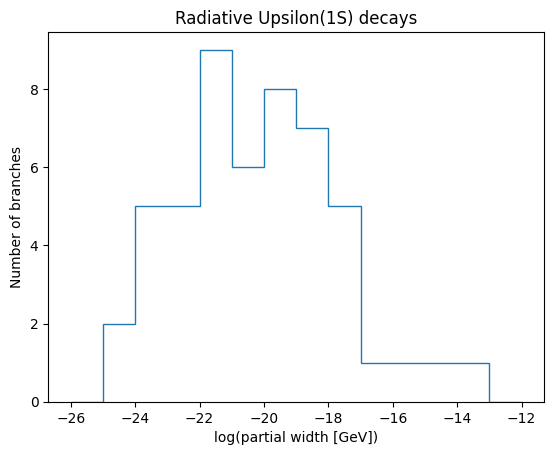

In [29]:
def produces_gamma(branch: pdg.decay.PdgBranchingFraction):
    return any(p.item.has_particle
               and p.item.particle.name == api.get_canonical_name('gamma')
               for p in branch.decay_products)

p = api.get_particle_by_name('Upsilon(1S)')
selected_branches = [branch for branch in p.branching_fractions()
                    if produces_gamma(branch)]
log_partial_widths = [np.log(p.width * b.value) for b in selected_branches]

plt.hist(log_partial_widths, histtype='step', bins=np.linspace(-26, -12, 15));
plt.xlabel("log(partial width [GeV])")
plt.ylabel('Number of branches')
plt.title('Radiative Upsilon(1S) decays');

### Plotting masses of all decay products of the $D^+$

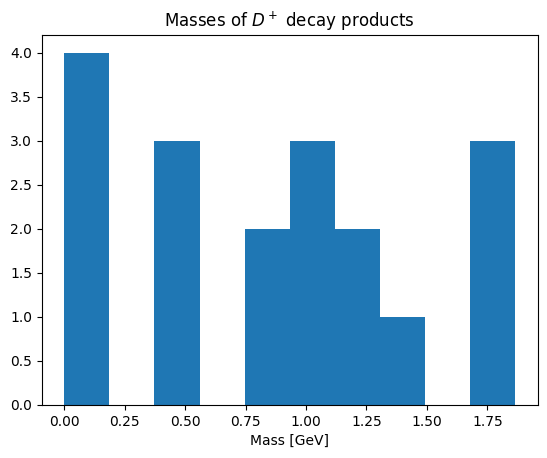

In [30]:
all_masses = set()
p = api.get_particle_by_name('D+')
for decay in p.exclusive_branching_fractions():
    for prod in decay.decay_products:
        if not prod.item.has_particle:
            continue
        if prod.item.particle.has_mass_entry:
            # Since a mass entry could be a limit, rather than a measurement,
            # we must perform a check:
            if prod.item.particle.mass is not None:
                all_masses.add(prod.item.particle.mass)
plt.hist(all_masses);
plt.xlabel('Mass [GeV]')
plt.title('Masses of $D^+$ decay products');

### Plotting $K^+$ mass over time

For this, you will need the "pdgall" database file from https://pdg.lbl.gov/2024/api/index.html.

In [31]:
api_all = pdg.connect("sqlite:///pdgall-2024-v0.1.0.sqlite")

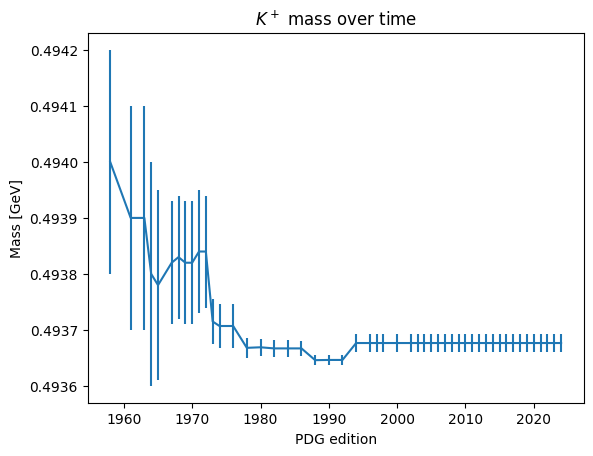

In [32]:
xs, ys, yerrs = [], [], []
for edition in api_all.editions:
    p = api_all.get_particle_by_name('K+', edition=edition)
    if p.has_mass_entry and p.mass is not None:
        xs.append(int(edition))
        ys.append(p.mass)
        yerrs.append(p.mass_error)

plt.errorbar(xs, ys, yerrs)
plt.xlabel('PDG edition')
plt.ylabel('Mass [GeV]')
plt.title('$K^+$ mass over time');

### Printing all neutrino mixing properties

Neutrino mixing properties all live under the `S067` parent identifier (as can be seen, for example, by browsing pdgLive). Let's print them all:

In [33]:
parent = api.get('S067')
for prop in parent.get_children():
    if prop.has_best_summary():
        print(f'{prop.baseid:10s} {prop.value:8f} {prop.description}')

S067SDN    0.033000 Day-Night Asymmetry (B8)
S067P12    0.307000 sin**2(theta(12))
S067DM3    0.000075 Deltam(21)**2
S067P23    0.552989 sin**2(theta(23))
S067DM1    -0.002529 Deltam(32)**2
S067P13    0.021866 sin**2(theta(13))
S067DEL    1.186745 delta, CP violating phase
S067CPT    0.000110 <Deltamass**2(21)-Deltambar(21)**2>
S067CP2    -0.000120 <Deltamass**2(32)-Deltambar(32)**2>


## Closing words

This concludes our tour of the PDG API. Thanks for following along! We hope that you are now positioned to start making use of the API, and we welcome your feedback.